## 儲存OK Canny圖片

In [1]:
import numpy as np
import cv2 as cv
from imutils import paths
import os

In [2]:
train_path = '.\\Dataset\\OK\\Canny\\train'
test_path = '.\\Dataset\\OK\\Canny\\test'
if not os.path.isdir(train_path):
    os.makedirs(train_path)
if not os.path.isdir(test_path):
    os.makedirs(test_path)

In [3]:
imagePaths_train = sorted(list(paths.list_images(".\\Dataset\\OK\\train")))
imagePaths_test = sorted(list(paths.list_images(".\\Dataset\\OK\\test")))

i=0
j=0
for imagePath in imagePaths_train:
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    canny = cv.Canny(gray, 50, 150)
    if i<=9:
        cv.imwrite('.\\Dataset\\OK\\Canny\\train\\0%d.jpg'%(i), canny)

    if i>9:
        cv.imwrite('.\\Dataset\\OK\\Canny\\train\\%d.jpg'%(i), canny)
    i=i+1
for imagePath in imagePaths_test:
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    canny = cv.Canny(gray, 50, 150)
    cv.imwrite('.\\Dataset\\OK\\Canny\\test\\0%d.jpg'%(j), canny)
    j=j+1

## 以Canny邊緣為特徵的MLP辨識模型

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import cv2
import os
import matplotlib.pyplot as plt

from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense

### 訓練模型

In [6]:
imagePaths_train = sorted(list(paths.list_images(".\\Dataset\\OK\\Canny\\train")))
imagePaths_test = sorted(list(paths.list_images(".\\Dataset\\OK\\Canny\\test")))

#IMAGE_DIMS = (32, 32, 3)
train_feature = []
train_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
test_feature = []
test_label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [7]:
for imagePath in imagePaths_train:
    #print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath, 0)
    image = img_to_array(image)
    train_feature.append(image)
for imagePath in imagePaths_test:
    #print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath, 0)
    image = img_to_array(image)
    test_feature.append(image)

In [8]:
train_feature = np.array(train_feature, dtype="float")
test_feature = np.array(test_feature, dtype="float")
train_label = np.array(train_label)
test_label = np.array(test_label)

print("Train Data shape:" + str(train_feature.shape))
print("Test Data shape:" + str(test_feature.shape))
print("Train Label shape:" + str(train_label.shape))
print("Test Label shape:" + str(test_label.shape))

Train Data shape:(40, 32, 32, 1)
Test Data shape:(10, 32, 32, 1)
Train Label shape:(40,)
Test Label shape:(10,)


In [9]:
def show_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='gray')
    plt.show() 

def show_images_labels_predictions(images,labels,
                                  predictions,start_id,num=10):
    plt.gcf().set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        #顯示黑白圖片
        ax.imshow(images[start_id], cmap='gray')
        
        # 有 AI 預測結果資料, 才在標題顯示預測結果
        if( len(predictions) > 0 ) :
            title = 'ai = ' + str(predictions[start_id])
            # 預測正確顯示(o), 錯誤顯示(x)
            title += (' (o)' if predictions[start_id]==labels[start_id] else ' (x)') 
            title += '\nlabel = ' + str(labels[start_id])
        # 沒有 AI 預測結果資料, 只在標題顯示真實數值
        else :
            title = 'label = ' + str(labels[start_id])
            
        # X, Y 軸不顯示刻度    
        ax.set_title(title,fontsize=12) 
        ax.set_xticks([]);ax.set_yticks([])        
        start_id+=1 
    plt.show()

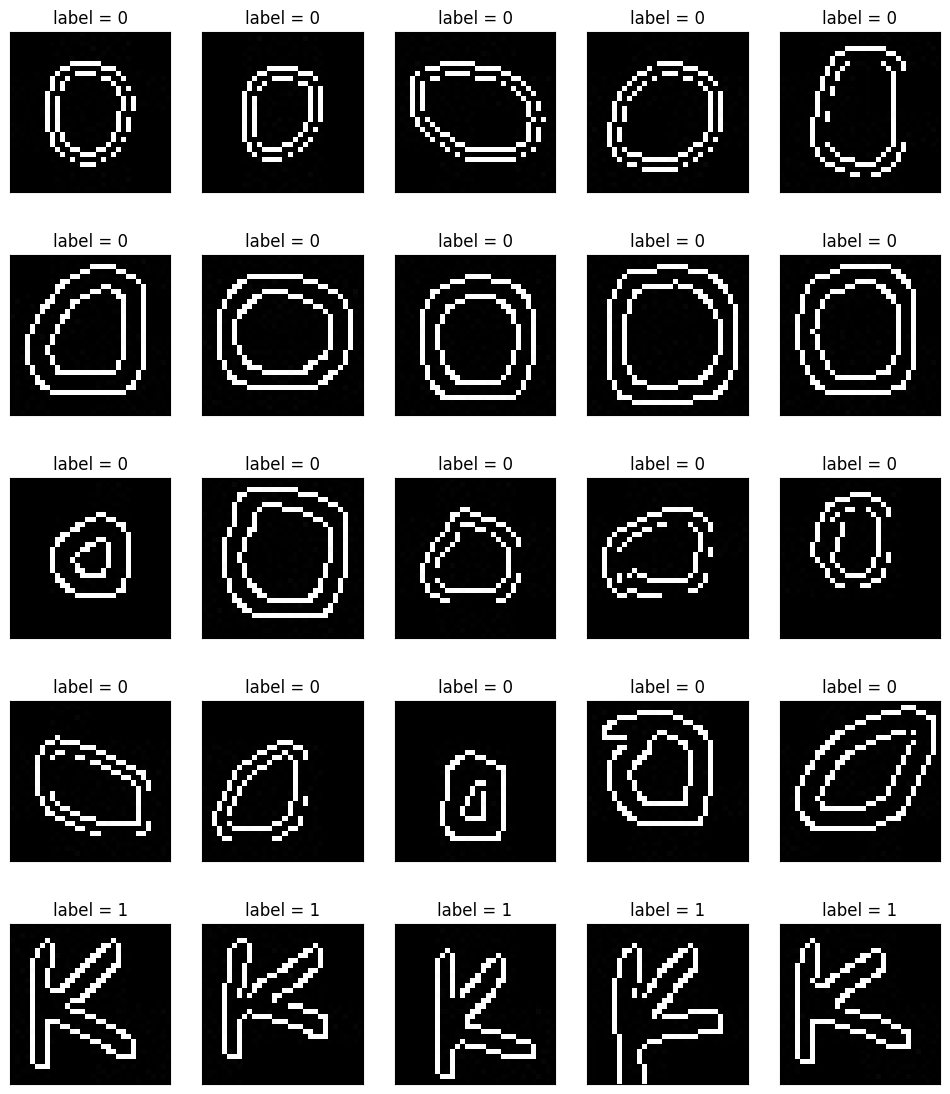

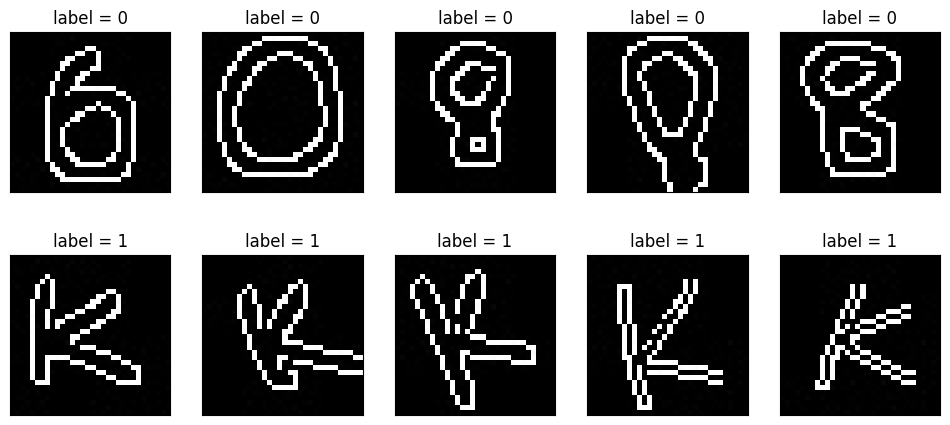

In [10]:
show_images_labels_predictions(train_feature,train_label,[],0,40)
show_images_labels_predictions(test_feature,test_label,[],0,10)

In [11]:
#將 Features 特徵值轉換為 784個 float 數字的 1 維向量
train_feature_vector =train_feature.reshape(len(train_feature), 1024).astype('float32')
test_feature_vector = test_feature.reshape(len( test_feature), 1024).astype('float32')
print(train_feature_vector)
print(train_feature_vector.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 1.]
 ...
 [0. 0. 2. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]
(40, 1024)


In [12]:
#Features 特徵值標準化
train_feature_normalize = train_feature_vector/255
test_feature_normalize = test_feature_vector/255
print(train_feature_normalize)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01176471 ... 0.         0.         0.00392157]
 ...
 [0.         0.         0.00784314 ... 0.00392157 0.         0.        ]
 [0.00392157 0.         0.00392157 ... 0.         0.         0.        ]
 [0.00392157 0.00392157 0.         ... 0.         0.         0.        ]]


In [13]:
#label 轉換為 One-Hot Encoding 編碼
train_label_onehot = to_categorical(train_label)
test_label_onehot = to_categorical(test_label)
print(test_label_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
#建立模型
model = Sequential()
#輸入層：1024, 隱藏層：256，輸出層：2
model.add(Dense(units=256, 
                input_dim=1024, 
                kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(units=2, 
                kernel_initializer='normal', 
                activation='softmax'))
model.summary()  # 模型可視化


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262914 (1.00 MB)
Trainable params: 262914 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
#定義訓練方式
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

#以(train_feature_normalize,train_label_onehot)資料訓練，
#訓練資料保留 20% 作驗證,訓練20次、每批次讀取4筆資料，顯示簡易訓練過程
train_history =model.fit(x=train_feature_normalize,
                         y=train_label_onehot,validation_split=0.2, 
                         epochs=20, batch_size=4,verbose=2)

Epoch 1/20


8/8 - 1s - loss: 0.6401 - accuracy: 0.5938 - val_loss: 0.9029 - val_accuracy: 0.2500 - 541ms/epoch - 68ms/step
Epoch 2/20
8/8 - 0s - loss: 0.1958 - accuracy: 0.9688 - val_loss: 0.5509 - val_accuracy: 0.6250 - 47ms/epoch - 6ms/step
Epoch 3/20
8/8 - 0s - loss: 0.0802 - accuracy: 1.0000 - val_loss: 0.3954 - val_accuracy: 0.8750 - 37ms/epoch - 5ms/step
Epoch 4/20
8/8 - 0s - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.4024 - val_accuracy: 0.8750 - 37ms/epoch - 5ms/step
Epoch 5/20
8/8 - 0s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.4395 - val_accuracy: 0.8750 - 37ms/epoch - 5ms/step
Epoch 6/20
8/8 - 0s - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.4388 - val_accuracy: 0.8750 - 38ms/epoch - 5ms/step
Epoch 7/20
8/8 - 0s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.4193 - val_accuracy: 0.8750 - 43ms/epoch - 5ms/step
Epoch 8/20
8/8 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.3961 - val_accuracy: 0.8750 - 41ms/epoch - 5ms/step
Epoch 9/20
8/8 - 0s - loss: 0.0046 -

In [16]:
#評估準確率
scores = model.evaluate(test_feature_normalize, test_label_onehot)
print('\n準確率=',scores[1])

1/1 [==============================] - 0s 85ms/step - loss: 0.4015 - accuracy: 0.8000

準確率= 0.800000011920929


In [17]:
#將模型儲存至 HDF5檔案中
model.save('OK_canny_model.h5')

c:\01_MLP\nnenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 測試模型

In [18]:
predict=model.predict(test_feature_normalize)
prediction=np.argmax(predict,axis=1)

1/1 [==============================] - 0s 57ms/step


In [19]:
# 顯示圖片及預測結果的函數
import random

def plot_images_labels_prediction(images, labels, prediction=[], names=[], predictions_array=[], num=20):
    # 取得 pyplot 物件參考
    fig = plt.gcf()

    # 設定畫布大小為 12 吋*14吋
    fig.set_size_inches(12, 14)

    idx = random.randint(0, images.shape[0] - 1)

    # 限制最多顯示 20 個子圖
    if num > 20: num = 20

    # 依序顯示 num 個子圖
    for i in range(0, num):
        # 建立 5*5 個子圖中的第 i+1 個 
        ax = plt.subplot(5, 5, i + 1)

        # 顯示子圖
        ax.imshow(images[idx], cmap='gray')

        title = ""
        color = 'black'
        label = labels[idx]
        pred = None

        # 有預測值就加入標題中
        if len(prediction) > 0:
            if prediction[idx] != labels[idx]:
                color = 'red'
                confidence = 100 * np.min(predictions_array[idx])
            else:
                color = 'blue'
                confidence = 100 * np.max(predictions_array[idx])
            pred = prediction[idx]
        
        if len(names) > 0:
            # print(names)
            # print(label)
            label = names[label]
            if pred != None:
                pred = names[pred]

        title = "label = " + str(label)
        if pred != None: title += "\npredict = " + str(pred)

        title = "{}\nscore={:2.2f}%".format(title, confidence)

        # 設定標題
        ax.set_title(title, fontsize=10, color=color) 
        
        # 不顯示 x 、y軸刻度
        ax.set_xticks([]);  
        ax.set_yticks([]);
        
        # 樣本序號增量 1
        idx += 1    
        if idx >= images.shape[0]:
            idx = 0
    
    # 繪製圖形
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()

In [20]:
print(test_feature.shape)
print(np.argmax(test_label_onehot, axis=1))
print(np.argmax(predict, axis=1))

(10, 32, 32, 1)
[0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 1 0 0 1 1]


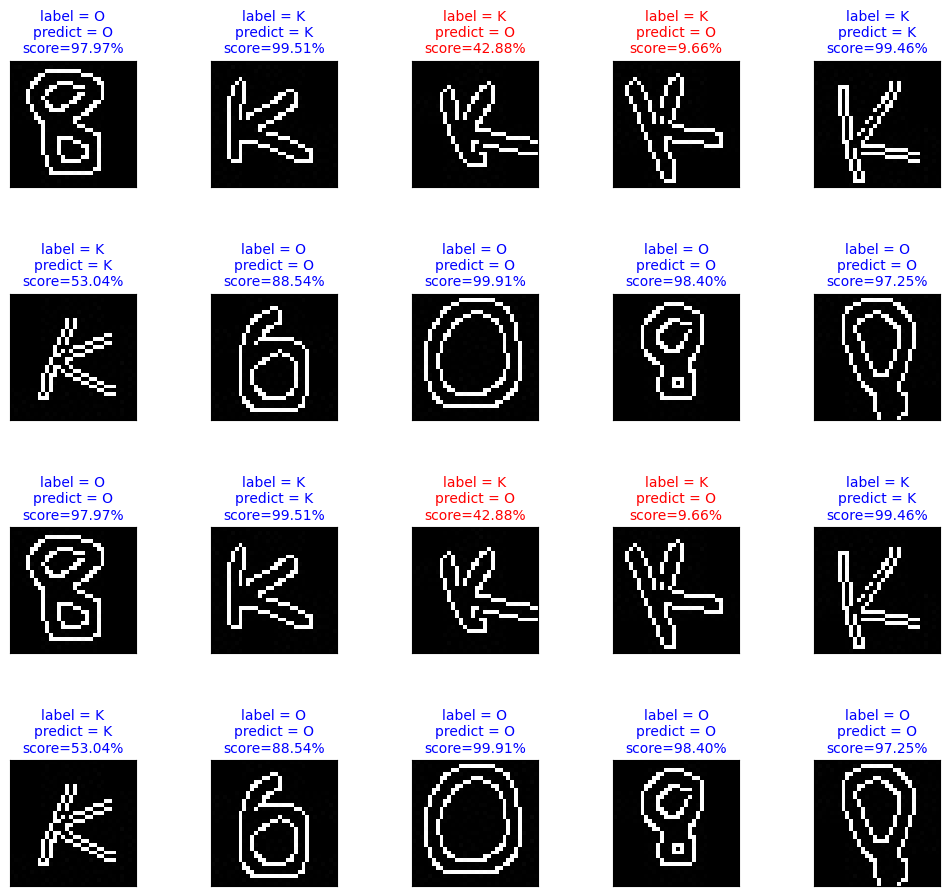

In [21]:
NAMES = ['O', 'K']
plot_images_labels_prediction(test_feature, np.argmax(test_label_onehot, axis=1), np.argmax(predict, axis=1), NAMES, predictions_array=predict)